In [2]:
from scipy.stats import poisson,norm
from math import log
from scipy.integrate import simpson
from scipy.optimize import minimize
from functools import partial
from scipy.integrate import quad
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm

def model_poisson(n,s,b):
    return poisson(s+b).pmf(n)

def prior_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

def constraint_b(b,bmu,sigmab):
    return norm(loc=bmu,scale=sigmab).pdf(b)

# prior_b and constraint_b practically equal, conceptually different
def model_constraint_bayes(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*prior_b(b,bbar,sigmab)
    
def model_constraint_freq(n,s,b,bbar,sigmab):
    return model_poisson(n,s,b)*constraint_b(bbar,b,sigmab)

def model_poisson_2d(n,x):
    s = x[0]
    b = x[1]
    return model_poisson(n,s,b)
    
def model_constraint_2d_freq(n,x,bbar,sigmab):
    s = x[0]
    b = x[1]
    return model_constraint_freq(n,s,b,bbar,sigmab)

def nll(model,n,s,b,**kwargs):
    return -np.log(model(n,s,b,**kwargs))

def nll_2d(model,n,x,**kwargs):
    return -np.log(model(n=n,x=x,**kwargs))

def nll_2dd(model,n, bbar, sigmab,x,**kwargs):
    return -np.log(model(n=n, bbar =bbar,sigmab=sigmab ,x=x,**kwargs))

def integral_2d(f,x,y):
    zz = f(x.reshape(-1,1),y.reshape(1,-1))
    return simpson([simpson(zz_y,y) for zz_y in zz],x) 
    
def posterior(model,n,b=None,s=np.linspace(0,10,101),profile_b=False,TwoD = False,**kwargs):
    if type(b) is int or type(b) is float: # fixed b
        integralmodel = quad(partial(model,n,b=b,**kwargs),0,np.inf)[0]
        return model(n,s,b,**kwargs)/integralmodel
    else: # b not fixed
        if profile_b: # optimise b
            post = []
            for s_i in s:
                res=minimize(partial(nll,model,n,s_i,**kwargs),x0=(3,),bounds=[(0,np.inf)])
                optimalb = res.x[0]
                post.append(model(n=n,s=s_i,b=optimalb,**kwargs))
            post = np.array(post)
            integralmodel = simpson(post,s)
            return post/integralmodel
        else: # integrate b
            post = []
            integral = integral_2d(partial(model,n,**kwargs),s,b)
            if TwoD: # Posterior 2D (s,b)
                return model(n,s = s.reshape(1,-1),b = b.reshape(-1,1),**kwargs)/integral
            else: # Posterior 1D (s) / integrate b
                integral_b = simpson(model(n,s.reshape(-1,1),b.reshape(1,-1),**kwargs),b,axis=1)
                return integral_b/integral

def testStatistic(model,n,s,b,bestNLL,**kwargs):
    return 2*(nll(model=model,n=n,s=s,b=b,**kwargs)-bestNLL)

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.rc('legend',fontsize=15)
plt.rc('font',size=15)

100%|██████████| 5/5 [00:52<00:00, 10.50s/it]


	 n=0 	 n=1 	 n=2 	 n=3 	 n=4
b=0	2.302	3.889	5.322	6.680	7.993
b=1	2.302	3.271	4.442	5.711	6.999
b=2	2.302	2.994	3.877	4.925	6.087
b=3	2.302	2.838	3.522	4.362	5.344
b=4	2.302	2.739	3.288	3.966	4.779


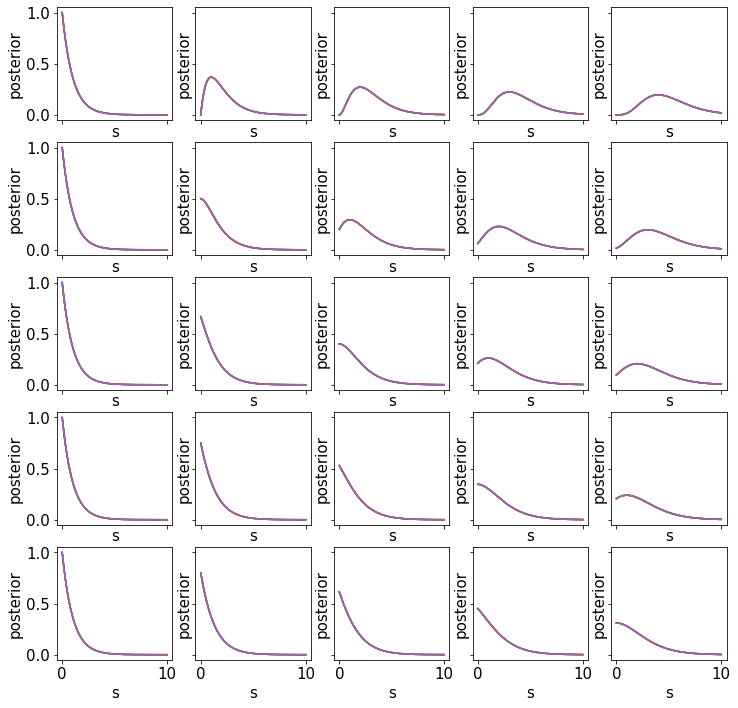

In [4]:
upper_limits = {}
fig,axs=plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12,12))
s = np.linspace(0,10,10001)
sigmab = 2
for bbar in tqdm(range(5)):
    for b in range(5):
        for n in range(5):
            post = posterior(model=model_constraint_bayes,n=n,b=b,s=s, bbar=bbar,sigmab=sigmab) #model_constraint_bayes
            cum_int = cumulative_trapezoid(post,s)
            CL = 0.9
            idx = (cum_int>CL).argmax()
            upper_limits[(n,b)] = s[idx]
            plt.sca(axs[b,n])
            plt.xlabel('s',fontsize=15)
            plt.ylabel('posterior',fontsize=15)
            plt.plot(s,post)

print('\t n=0 \t n=1 \t n=2 \t n=3 \t n=4')
for b in range(0,5):
    print('b='+str(b)+'\t'+( '\t'.join(['%.3f'%upper_limits[(n,b)] for n in range(0,5)]) ) )

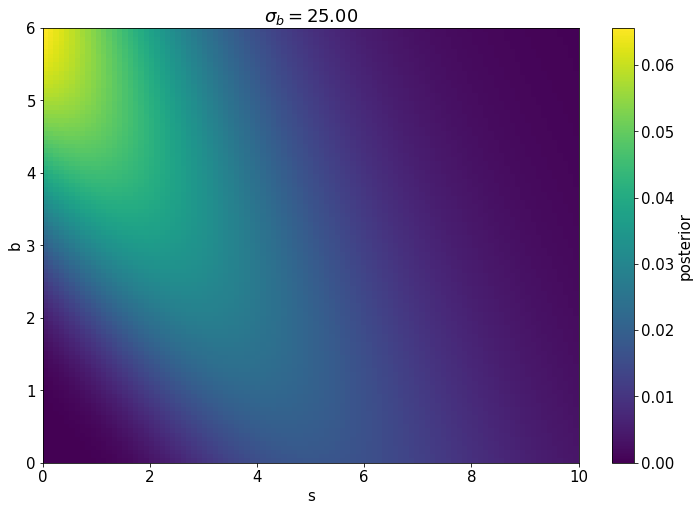

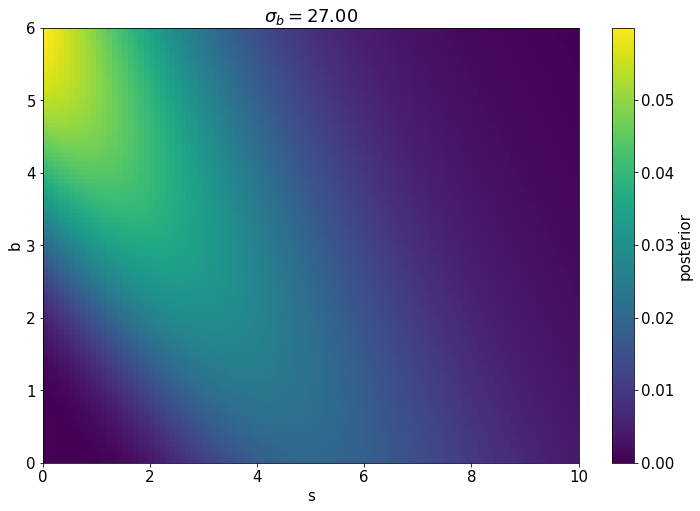

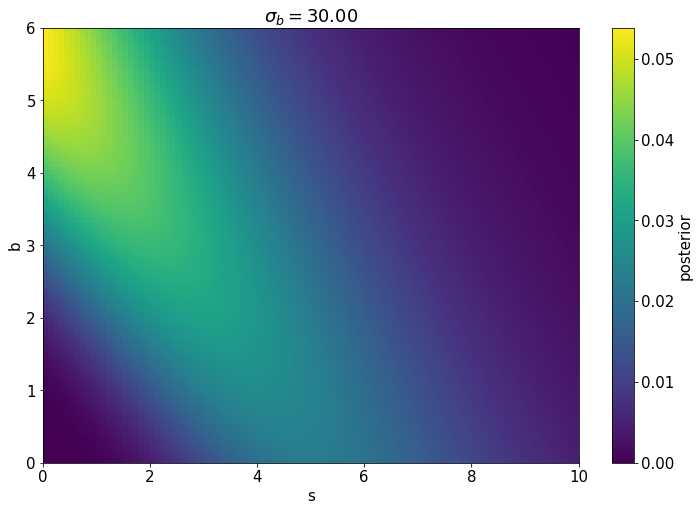

In [39]:
n = 5
bbar = 150
s = 50
for sigmab in [25,27,30.0]:
    plt.figure()
    s = np.linspace(0,10,101)
    b = np.linspace(0,6,101)
    sv,bv = np.meshgrid(s,b)
    plt.title(r'$\sigma_b = %.2f$'%sigmab)
    plt.hist2d(sv.flatten(),bv.flatten(),weights = posterior(model_constraint_bayes,n=n,s=s,b=b,bbar=bbar,sigmab=sigmab,TwoD=True).flatten(),bins=[len(s),len(b)])
    plt.colorbar().set_label('posterior',fontsize=15)
    plt.xlabel('s',fontsize=15)
    plt.ylabel('b',fontsize=15)

Text(0, 0.5, 'posterior')

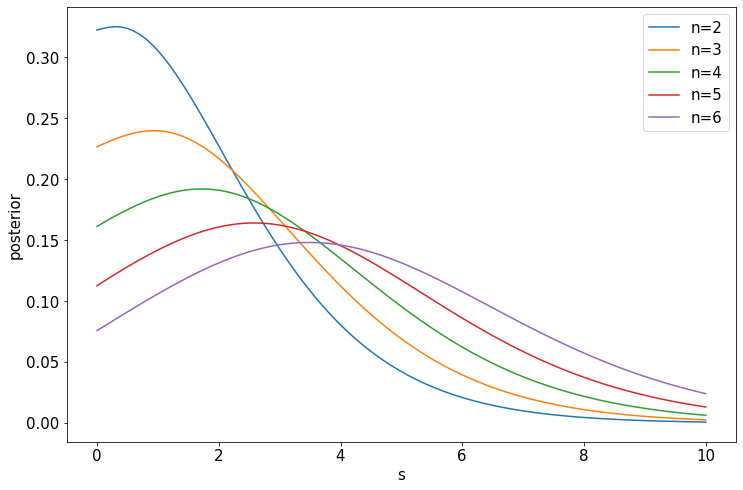

In [5]:
plt.figure()
s = np.linspace(0,10,101)
for n in range(2,7):
    plt.plot(s,posterior(model=model_constraint_bayes,n=n,s=s,b=np.linspace(0,6,81),bbar=bbar,sigmab=30),label='n=%d'%n)
plt.legend(loc='best')
plt.xlabel('s',fontsize=15)
plt.ylabel('posterior',fontsize=15)

# APPROCCIO FREQUENTUSTA

In [6]:
# A normal function
def f(a, b, c, x):
    return 1000*a + 100*b + 10*c + x
  
# A partial function that calls f with
# a as 3, b as 1 and c as 4.
g = partial(f, 3, 1, 4)
  


In [7]:
# Calling g()
print(g(5))

3145


In [8]:
#il partila rende una funzione non più con parametri liberi ma che dipende solo da x.

In [9]:
bestNLL

NameError: name 'bestNLL' is not defined

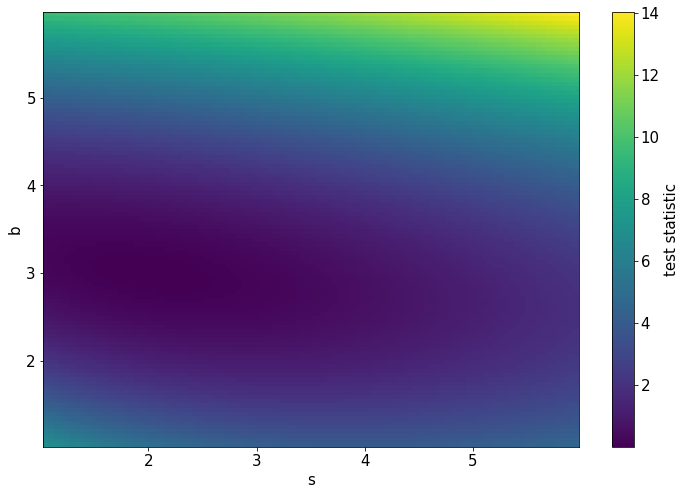

In [10]:
n=5
bbar = 3 #x0=(3,2) punti di partenza di s e b.
sigmab = 1
#res=minimize(partial(nll_2dd,model_constraint_2d_freq,n,bbar,sigmab),x0=(3,2),bounds=[(0,np.inf),(0,np.inf),])
res=minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(0,1),bounds=[(0,np.inf),(0,np.inf),])
bestNLL = res.fun
b = np.linspace(1,6,101)
b = 0.5*(b[1:]+b[:-1])
s = np.linspace(1,6,101)
s = 0.5*(s[1:]+s[:-1])
sv, bv = np.meshgrid(s,b)

t = testStatistic(model = model_constraint_freq, n=n,bbar = bbar, s=sv, b=bv, sigmab=sigmab , bestNLL = bestNLL)
plt.hist2d(sv.flatten(),bv.flatten(),weights=t.flatten(),bins=[100,100])
plt.colorbar().set_label('test statistic',fontsize=15)
plt.xlabel('s',fontsize=15)
plt.ylabel('b',fontsize=15)
plt.savefig("schiz.png", bbox_inches='tight')

In [11]:
from scipy.stats import chi2
coverage_sigma1 = norm.cdf(1)-norm.cdf(-1)
coverage_sigma2 = norm.cdf(2)-norm.cdf(-2)
coverage_sigma3 = norm.cdf(3)-norm.cdf(-3)
coverage_sigma1

0.6826894921370859

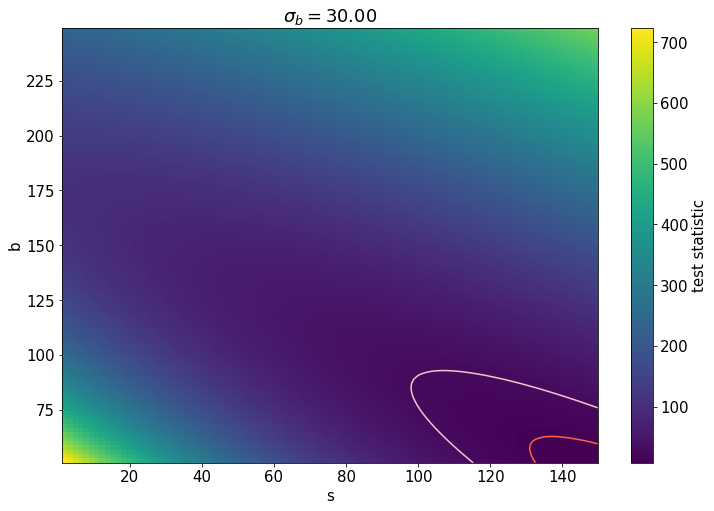

In [12]:
n=200
b = np.linspace(50,250,101)
b = 0.5*(b[1:]+b[:-1])
s = np.linspace(1,150,301)
s = 0.5*(s[1:]+s[:-1])
sv, bv = np.meshgrid(s,b)

from scipy.stats import chi2
coverage_sigma1 = norm.cdf(1)-norm.cdf(-1)
coverage_sigma2 = norm.cdf(2)-norm.cdf(-2)
coverage_sigma3 = norm.cdf(3)-norm.cdf(-3)

#for sigmab in [0.25,1.,1.25,1.5,2.0]:
sigmab = 30
res=minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(50,150),bounds=[(0,np.inf),(0,np.inf),])
bestNLL = res.fun
t = testStatistic(model = model_constraint_freq, n=n, s=sv, b=bv, bestNLL = bestNLL, bbar = bbar, sigmab = sigmab)
plt.figure()
plt.title(r'$\sigma_b=%.2f$'%sigmab)
plt.hist2d(sv.flatten(),bv.flatten(),weights=t.flatten(),bins=[100,100])
plt.colorbar().set_label(label='test statistic',fontsize=15)
plt.contour(s,b,t,[chi2(1).ppf(coverage_sigma1),chi2(1).ppf(coverage_sigma2),chi2(1).ppf(coverage_sigma3)],colors=['red','tomato','pink'])
plt.scatter(res.x[0],res.x[1])
plt.xlabel('s',fontsize=15)
plt.ylabel('b',fontsize=15)
plt.savefig("schiz.png", bbox_inches='tight')

In [111]:
limit = chi2(1).ppf(0.9)
limit

2.705543454095404

In [134]:
limit1 = chi2(1).ppf(coverage_sigma1)
limit2 = chi2(1).ppf(coverage_sigma2)
limit3 = chi2(1).ppf(coverage_sigma3)
limit  = limit1, limit2, limit3

In [151]:
cov = coverage_sigma1, coverage_sigma2, coverage_sigma3

In [1]:

#limit = chi2(1).ppf(0.8) # 90% one sided CL
limit1 = chi2(1).ppf(coverage_sigma1)
limit2 = chi2(1).ppf(coverage_sigma2)
limit3 = chi2(1).ppf(coverage_sigma3)
limit  = limit1, limit2, limit3
#for i in [0,1,2]:
n=200
#s = np.linspace(30,90,751)
s = np.linspace(1,150,301)
s = 0.5*(s[1:]+s[:-1])
sigmab = 30
res = minimize(partial(nll_2d,model_constraint_2d_freq,n,bbar=bbar,sigmab=sigmab),x0=(2,3),bounds=[(0,np.inf),(0,np.inf),])
bestNLL = res.fun
t = np.array([])
for si in s:
    res = minimize(partial(nll,model_constraint_freq,n,si,bbar=bbar,sigmab=sigmab),x0=(150,),bounds=[(0,np.inf),])
    t = np.append(t,testStatistic(model=model_constraint_freq,n=n,s=si,b=res.x[0],bestNLL=bestNLL,bbar=bbar,sigmab=sigmab))
p = plt.plot(s,t,label=r'$\sigma_b=%.2f$'%limit1,lw=1)
idx = (t>limit1).argmax()
upper_limit = 0.5*(s[idx]+s[idx-1])
print('sigmab = %.2f, upper limit = %.2f'%(sigmab,upper_limit))
plt.vlines(upper_limit,0,limit1,lw=1,color=p[0].get_color())
plt.xlabel('s',fontsize=15)
plt.axhline(limit1,color='black',lw=1)
plt.legend(loc='best')

NameError: name 'chi2' is not defined